In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import os
import math
from ast import literal_eval
from collections import defaultdict
from matplotlib_venn import venn3, venn3_circles
from matplotlib_venn import venn2, venn2_circles


# Datasets

## Genres and Platforms

In [61]:
df_genres = pd.read_csv('../final_dataset/genres.csv')
df_genres.columns = ['genre_id', 'genre_name']

df_platforms = pd.read_csv('../final_dataset/platforms.csv', header=None)
df_platforms.columns = ['platform_id', 'platform_name']

dict_platform_nintendo = {
    137:"New Nintendo 3DS",
    37:"Nintendo 3DS",
    4:"Nintendo 64",
    416:"Nintendo 64DD",
    20:"Nintendo DS",
    159:"Nintendo DSi",
    18:"Nintendo Entertainment System",
    21:"Nintendo GameCube",
    131:"Nintendo PlayStation",
    130:"Nintendo Switch",
    19:"Super Nintendo Entertainment System",
    5:"Wii",
    41:"Wii U"
}

dict_platform_playstation = {
    38:"PlayStation Portable",
    9:"PlayStation 3",
    131:"Nintendo PlayStation",
    46:"PlayStation Vita",
    48:"PlayStation 4",
    167:"PlayStation 5",
    7:"PlayStation",
    390:"PlayStation VR2",
    165:"PlayStation VR",
    8:"PlayStation 2"
}
        
dict_platform_xbox = {
    11:"Xbox",
    12:"Xbox 360",
    49:"Xbox One",
    169:"Xbox Series X|S"
}

dict_platform_pc = {
    6 : "PC (Microsoft Windows)",
    3: "Linux",
    163: "SteamVR",
    162: "Oculus VR",
    13: "DOS",
    161: "Windows Mixed Reality",
    14: "Mac",
    16: "Amiga",
    386: "Meta Quest 2",
    27: "MSX"
}

dict_platform = {
    **dict_platform_nintendo, 
    **dict_platform_playstation, 
    **dict_platform_xbox, 
    **dict_platform_pc
}

# show genres columns
df_genres.head()

# list all platforms that are not in dict_platform_xbox, dict_platform_nintendo, dict_platform_playstation
df_platforms_pc = df_platforms[~df_platforms['platform_id'].isin(dict_platform_xbox.keys()) & ~df_platforms['platform_id'].isin(dict_platform_nintendo.keys()) & ~df_platforms['platform_id'].isin(dict_platform_playstation.keys())]

# put the df_platforms_pc at dict_platform_pc
dict_platform_pc = dict(zip(df_platforms_pc['platform_id'], df_platforms_pc['platform_name']))

dict_platform


{137: 'New Nintendo 3DS',
 37: 'Nintendo 3DS',
 4: 'Nintendo 64',
 416: 'Nintendo 64DD',
 20: 'Nintendo DS',
 159: 'Nintendo DSi',
 18: 'Nintendo Entertainment System',
 21: 'Nintendo GameCube',
 131: 'Nintendo PlayStation',
 130: 'Nintendo Switch',
 19: 'Super Nintendo Entertainment System',
 5: 'Wii',
 41: 'Wii U',
 38: 'PlayStation Portable',
 9: 'PlayStation 3',
 46: 'PlayStation Vita',
 48: 'PlayStation 4',
 167: 'PlayStation 5',
 7: 'PlayStation',
 390: 'PlayStation VR2',
 165: 'PlayStation VR',
 8: 'PlayStation 2',
 11: 'Xbox',
 12: 'Xbox 360',
 49: 'Xbox One',
 169: 'Xbox Series X|S',
 6: 'PC (Microsoft Windows)',
 3: 'Linux',
 163: 'SteamVR',
 162: 'Oculus VR',
 13: 'DOS',
 161: 'Windows Mixed Reality',
 14: 'Mac',
 16: 'Amiga',
 386: 'Meta Quest 2',
 27: 'MSX'}

## IGDB + HLTB - Merged

In [62]:
if not os.path.exists('dataset_merged.csv'):

    PATH = '../final_dataset'

    dataset = pd.DataFrame()
    for platform in [f for f in os.listdir(PATH ) if 'all_games' in f]:
        # print(platform)

        df_platform = pd.DataFrame()
        
        try:
            df_platform = pd.read_csv(PATH + "/" +  platform, lineterminator='\n', encoding="utf-8")
            dataset = pd.concat([dataset, df_platform])
        except pd.errors.EmptyDataError:
            # print(file, " is empty and has been skipped.")    
            pass

    dataset['first_release_date'] = pd.to_datetime(dataset['first_release_date'], unit='s')

    # remove the duplicated ids
    dataset = dataset.drop_duplicates(subset=['id'], keep='first')    
    
    dataset.to_csv('dataset_merged.csv', index=False, encoding='utf-8', lineterminator='\n')


dataset = pd.read_csv('dataset_merged.csv', lineterminator='\n', encoding="utf-8",
                    converters={"id": str, 
                                "first_release_date": pd.to_datetime,
                                "platforms": literal_eval,
                                "genres": lambda x: x.strip("[]").split(", ") if x != 'Missing' else 'Missing'
                                })

dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99864 entries, 0 to 99863
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   first_release_date  99864 non-null  datetime64[ns]
 1   genres              99864 non-null  object        
 2   id                  99864 non-null  object        
 3   name                99863 non-null  object        
 4   platforms           99864 non-null  object        
 5   summary             99863 non-null  object        
 6   storyline           99419 non-null  object        
 7   rating              67005 non-null  object        
 8   main                37414 non-null  float64       
 9   extra               37414 non-null  float64       
 10  completionist       37414 non-null  float64       
 11  review_score        37414 non-null  float64       
 12  review_count        37414 non-null  float64       
      99864 non-null  object        
dtypes: dateti

In [63]:
# Total number of games
print("Total number of games: ", dataset.shape[0])

Total number of games:  99864


In [64]:
# show the missing values in the dataset
dataset.isnull().sum()

first_release_date        0
genres                    0
id                        0
name                      1
platforms                 0
summary                   1
storyline               445
rating                32859
main                  62450
extra                 62450
completionist         62450
review_score          62450
review_count          62450
people_polled\r           0
dtype: int64

In [65]:
# create a csv with the dataset with the platforms that are in dict_platform_xbox
dataset_xbox = dataset[dataset['platforms'].apply(lambda x: any(item in dict_platform_xbox.keys() for item in x))]
dataset_xbox.to_csv('dataset_xbox.csv', index=False, encoding='utf-8', lineterminator='\n')

# create a csv with the dataset with the platforms that are in dict_platform_nintendo
dataset_nintendo = dataset[dataset['platforms'].apply(lambda x: any(item in dict_platform_nintendo.keys() for item in x))]
dataset_nintendo.to_csv('dataset_nintendo.csv', index=False, encoding='utf-8', lineterminator='\n')

# create a csv with the dataset with the platforms that are in dict_platform_playstation
dataset_playstation = dataset[dataset['platforms'].apply(lambda x: any(item in dict_platform_playstation.keys() for item in x))]
dataset_playstation.to_csv('dataset_playstation.csv', index=False, encoding='utf-8', lineterminator='\n')

# create a csv with the dataset with the platforms that are in dict_platform_pc
dataset_pc = dataset[dataset['platforms'].apply(lambda x: any(item in dict_platform_pc.keys() for item in x))]
dataset_pc.to_csv('dataset_pc.csv', index=False, encoding='utf-8', lineterminator='\n')


In [66]:
# count each platform
print("Number of games in the xbox dataset: ", dataset_xbox.shape[0])
print("Number of games in the nintendo dataset: ", dataset_nintendo.shape[0])
print("Number of games in the playstation dataset: ", dataset_playstation.shape[0])
print("Number of games in the pc dataset: ", dataset_pc.shape[0])

# count the entries of all these datasets together
print("Total number of games in the datasets: ", dataset_xbox.shape[0] + dataset_nintendo.shape[0] + dataset_playstation.shape[0] + dataset_pc.shape[0])

Number of games in the xbox dataset:  14335
Number of games in the nintendo dataset:  23032
Number of games in the playstation dataset:  24040
Number of games in the pc dataset:  75906
Total number of games in the datasets:  137313


# Platform

## Games per platform

In [67]:
# number of games per platform
games_per_platform = dataset['platforms'].apply(lambda x: x[0]).value_counts().sort_values(ascending=False)

games_per_platform = pd.DataFrame(games_per_platform).reset_index().rename(columns={'platforms': 'platform_id'})
games_per_platform['platform_id'] = games_per_platform['platform_id'].astype(int)
games_per_platform = games_per_platform.merge(df_platforms, on='platform_id', how='left')
games_per_platform.sort_values(by='count', ascending=False)

games_per_platform['count'].sum()


99864

In [68]:
# show the platforms that are in dict_platform
games_per_platform[games_per_platform['platform_id'].isin(dict_platform.keys())].sort_values(by='count', ascending=False)   

# show the platforms that are not in dict_platform
# games_per_platform[~games_per_platform['platform_id'].isin(dict_platform.keys())].sort_values(by='count', ascending=False)

,platform_id,count,platform_name
0,6,64274,PC (Microsoft Windows)
1,3,9403,Linux
2,130,4653,Nintendo Switch
3,48,2980,PlayStation 4
4,8,2603,PlayStation 2
5,7,2259,PlayStation
6,20,2166,Nintendo DS
7,9,1501,PlayStation 3
8,49,1372,Xbox One
9,37,1308,Nintendo 3DS


In [69]:
# show a list of the platforms 
games_per_platform[games_per_platform['platform_id'].isin(dict_platform.keys())]['platform_name'].unique()

array(['PC (Microsoft Windows)', 'Linux', 'Nintendo Switch',
       'PlayStation 4', 'PlayStation 2', 'PlayStation', 'Nintendo DS',
       'PlayStation 3', 'Xbox One', 'Nintendo 3DS',
       'PlayStation Portable', 'Wii',
       'Super Nintendo Entertainment System', 'PlayStation Vita',
       'Xbox 360', 'Nintendo 64', 'Nintendo DSi',
       'Nintendo Entertainment System', 'Xbox', 'Nintendo GameCube',
       'PlayStation 5', 'PlayStation VR', 'Xbox Series X|S', 'SteamVR',
       'Wii U', 'Oculus VR', 'DOS', 'Windows Mixed Reality', 'Mac',
       'PlayStation VR2', 'Amiga', 'Meta Quest 2', 'Nintendo 64DD',
       'New Nintendo 3DS', 'MSX'], dtype=object)

## Single platform games (exclusives)

In [70]:

# only single platform games
dataset[dataset['platforms'].apply(lambda x: len(x) == 1)]

# show only the single platform games in their respective platform
games_single_platform = dataset[dataset['platforms'].apply(lambda x: len(x) == 1)]['platforms'].apply(lambda x: x[0]).value_counts()

games_single_platform = pd.DataFrame(games_single_platform).reset_index().rename(columns={'platforms': 'platform_id'})
games_single_platform['platform_id'] = games_single_platform['platform_id'].astype(int)
games_single_platform = games_single_platform.merge(df_platforms, on='platform_id', how='left')
games_single_platform.sort_values(by='count', ascending=False)

# total number of single platform games
print("Total number of single platform games: ", games_single_platform['count'].sum())

games_single_platform


Total number of single platform games:  61526


,platform_id,count,platform_name
0,6,43375,PC (Microsoft Windows)
1,130,4596,Nintendo Switch
2,20,1978,Nintendo DS
3,8,1711,PlayStation 2
4,7,1698,PlayStation
5,37,1174,Nintendo 3DS
6,38,1134,PlayStation Portable
7,48,833,PlayStation 4
8,49,745,Xbox One
9,9,640,PlayStation 3


# Genres

## Games per genre

In [71]:
# remove values missing values in a column
dataset['genres'].replace('Missing', np.nan, inplace=True)
# replace '' with np.nan
dataset['genres'].replace('', np.nan, inplace=True)

print("Number of games with missing genres: ", dataset['genres'].isnull().sum())

dataset['genres'].sort_values(ascending=True)

Number of games with missing genres:  9048


34507      []
95068    [10]
41073    [10]
41091    [10]
41158    [10]
         ... 
99824     NaN
99829     NaN
99831     NaN
99836     NaN
99837     NaN
Name: genres, Length: 99864, dtype: object

In [72]:
df_genres['genre_id'] 

0      4
1      5
2      7
3      8
4      9
5     10
6     11
7     12
8     13
9     14
10    15
11    16
12    24
13    26
14    25
15    30
16    31
17    33
18    34
19    32
20    35
21    36
22     2
Name: genre_id, dtype: int64

In [73]:
# remove genres values missing values
dataset_no_nas = dataset.dropna(subset=['genres'])
# remove lists with empty strings
dataset_no_nas = dataset_no_nas[dataset_no_nas['genres'].apply(lambda x: x[0] != '')]

games_per_genre = dataset_no_nas['genres'].apply(lambda x: x[0]).value_counts().sort_values(ascending=False)

games_per_genre = pd.DataFrame(games_per_genre).reset_index().rename(columns={'genres': 'genre_id'})
games_per_genre['genre_id'] = games_per_genre['genre_id'].astype(int)
df_genres['genre_id'] = df_genres['genre_id'].astype(int)
games_per_genre = games_per_genre.merge(df_genres, on='genre_id', how='left')
games_per_genre.sort_values(by='count', ascending=False)

games_per_genre['count'].sum()
games_per_genre


,genre_id,count,genre_name
0,31,11507,Adventure
1,5,11000,Shooter
2,12,10932,Role-playing (RPG)
3,13,10760,Simulator
4,32,8295,Indie
5,9,7185,Puzzle
6,8,6509,Platform
7,15,4866,Strategy
8,10,3916,Racing
9,4,2876,Fighting


In [74]:
# remove genres values missing values
dataset_xbox_no_nas = dataset_xbox.dropna(subset=['genres'])
# remove lists with empty strings
dataset_xbox_no_nas = dataset_xbox_no_nas[dataset_xbox_no_nas['genres'].apply(lambda x: x[0] != 'M')]

games_per_genre_xbox = dataset_xbox_no_nas['genres'].apply(lambda x: x[0]).value_counts().sort_values(ascending=False)
games_per_genre_xbox = pd.DataFrame(games_per_genre_xbox).reset_index().rename(columns={'genres': 'genre_id'})
games_per_genre_xbox['genre_id'] = games_per_genre_xbox['genre_id'].astype(int)
games_per_genre_xbox = games_per_genre_xbox.merge(df_genres, on='genre_id', how='left')
games_per_genre_xbox['platform'] = 'Xbox'

games_per_genre_xbox.sort_values(by='count', ascending=False)

# do the same for playstation
# remove genres values missing values
dataset_playstation_no_nas = dataset_playstation.dropna(subset=['genres'])
# remove lists with empty strings
dataset_playstation_no_nas = dataset_playstation_no_nas[dataset_playstation_no_nas['genres'].apply(lambda x: x[0] != 'M')]
games_per_genre_playstation = dataset_playstation_no_nas['genres'].apply(lambda x: x[0]).value_counts().sort_values(ascending=False)
games_per_genre_playstation = pd.DataFrame(games_per_genre_playstation).reset_index().rename(columns={'genres': 'genre_id'})
games_per_genre_playstation['genre_id'] = games_per_genre_playstation['genre_id'].astype(int)
games_per_genre_playstation = games_per_genre_playstation.merge(df_genres, on='genre_id', how='left')
games_per_genre_playstation['platform'] = 'Playstation'
games_per_genre_playstation.sort_values(by='count', ascending=False)

# do the same for nintendo
# remove genres values missing values
dataset_nintendo_no_nas = dataset_nintendo.dropna(subset=['genres'])
# remove lists with empty strings
dataset_nintendo_no_nas = dataset_nintendo_no_nas[dataset_nintendo_no_nas['genres'].apply(lambda x: x[0] != 'M')]
games_per_genre_nintendo = dataset_nintendo_no_nas['genres'].apply(lambda x: x[0]).value_counts().sort_values(ascending=False)
games_per_genre_nintendo = pd.DataFrame(games_per_genre_nintendo).reset_index().rename(columns={'genres': 'genre_id'})
games_per_genre_nintendo['genre_id'] = games_per_genre_nintendo['genre_id'].astype(int)
games_per_genre_nintendo = games_per_genre_nintendo.merge(df_genres, on='genre_id', how='left')
games_per_genre_nintendo['platform'] = 'Nintendo'
games_per_genre_nintendo.sort_values(by='count', ascending=False)

# do the same for pc
# remove genres values missing values
dataset_pc_no_nas = dataset_pc.dropna(subset=['genres'])
# remove lists with empty strings
dataset_pc_no_nas = dataset_pc_no_nas[dataset_pc_no_nas['genres'].apply(lambda x: x[0] != 'M')]
dataset_pc_no_nas = dataset_pc_no_nas[dataset_pc_no_nas['genres'].apply(lambda x: x[0] != '')]
games_per_genre_pc = dataset_pc_no_nas['genres'].apply(lambda x: x[0]).value_counts().sort_values(ascending=False)
games_per_genre_pc = pd.DataFrame(games_per_genre_pc).reset_index().rename(columns={'genres': 'genre_id'})
games_per_genre_pc['genre_id'] = games_per_genre_pc['genre_id'].astype(int)
games_per_genre_pc = games_per_genre_pc.merge(df_genres, on='genre_id', how='left')
games_per_genre_pc['platform'] = 'PC'
games_per_genre_pc.sort_values(by='count', ascending=False)

# merge all the platforms
games_per_genre_all = pd.concat([games_per_genre_xbox, 
                                 games_per_genre_playstation, 
                                 games_per_genre_nintendo, 
                                 games_per_genre_pc])

games_per_genre_all.sort_values(by='platform', ascending=False)

# make the table: index, platform, genre, count
games_per_genre_all = games_per_genre_all.reset_index().drop(columns=['index'])
games_per_genre_all = games_per_genre_all.reset_index()
games_per_genre_all = games_per_genre_all.rename(columns={'index': 'genre_rank'})
games_per_genre_all['genre_rank'] = games_per_genre_all['genre_rank'] + 1
games_per_genre_all = games_per_genre_all[['genre_rank', 'platform', 'genre_name', 'count']]
games_per_genre_all.sort_values(by='count', ascending=False)[:10]

# 

,genre_rank,platform,genre_name,count
68,69,PC,Adventure,10041
69,70,PC,Simulator,9014
70,71,PC,Role-playing (RPG),8873
71,72,PC,Shooter,8782
72,73,PC,Indie,8212
73,74,PC,Puzzle,4874
74,75,PC,Platform,4443
75,76,PC,Strategy,4345
23,24,Playstation,Shooter,3828
46,47,Nintendo,Platform,3410


# Year

## Games per Year

In [75]:

# games_per_year = dataset['first_release_date'].dt.year.value_counts().sort_index().reset_index()
# games_per_year.columns = ['year', 'count']
# games_per_year.sort_values(by='year', ascending=False)

# table with the number of games per year keep years type
dataset['first_release_date'].dt.year.value_counts()

# dataset.head()


first_release_date
2021    9049
2022    9018
2020    8282
2018    7814
2019    7739
2023    7677
2017    7238
2016    6127
2015    4503
2014    3203
2013    2503
2012    2287
2010    2201
2011    2175
2009    2048
2008    1939
2007    1780
2006    1680
2005    1403
2003    1283
2002    1251
2004    1227
1999    1164
2001    1158
2000    1124
1998    1088
1997     949
1996     732
1995     538
1994     387
1993     297
Name: count, dtype: int64

/var/folders/1f/dn5t35316d5b0gv0v6mcj6sm0000gn/T/ipykernel_7894/3146979078.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:,.0f}'.format(x) + 'K' for x in ax.get_yticks()/1000])


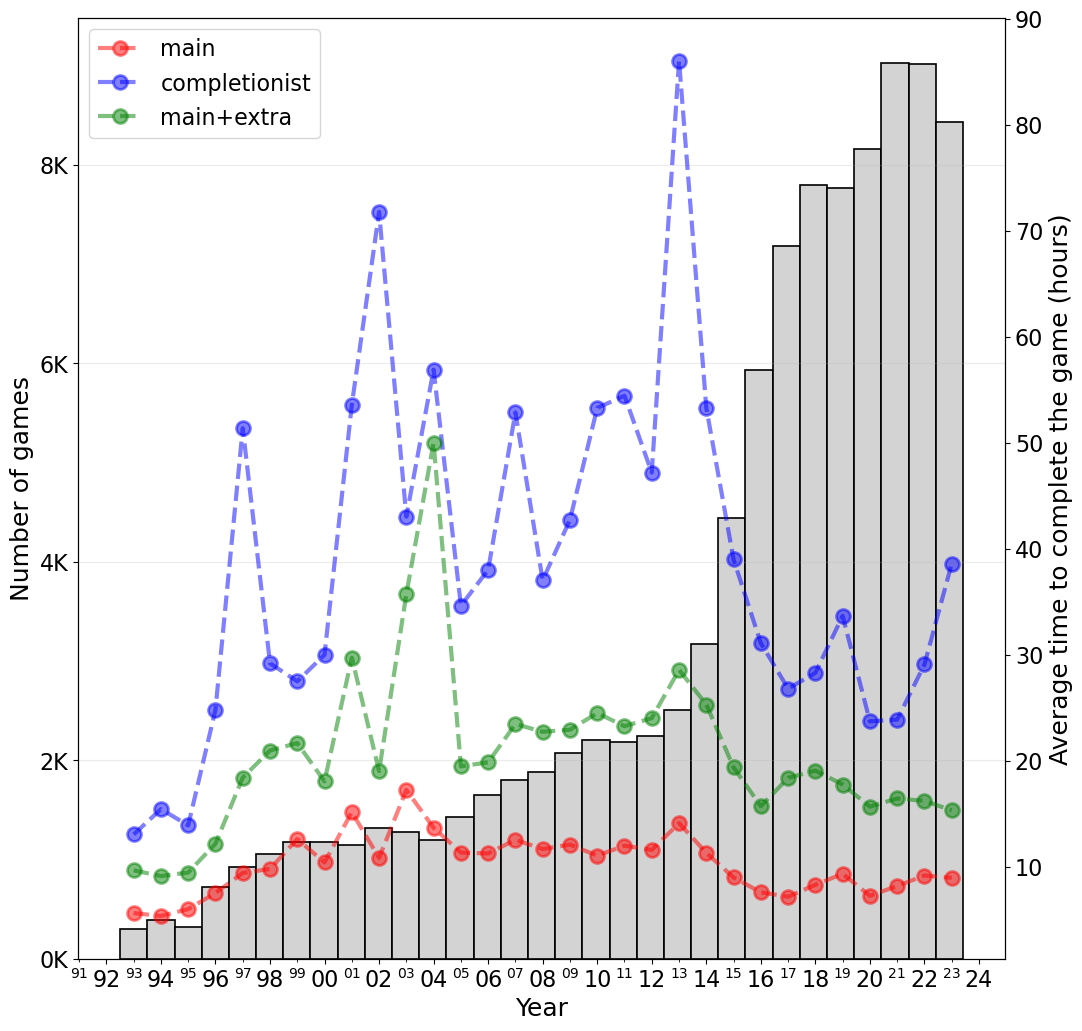

In [76]:
df = dataset
# only games that have a genre contains '12'
# df = dataset_no_nas[dataset_no_nas['genres'].apply(lambda x: '12' in x)]

fig, ax = plt.subplots(figsize=(10, 10))
fig.tight_layout()
# fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.2)

ax.hist(df['first_release_date'], 
        bins=len(df['first_release_date'].dt.year.unique()),
        color='lightgray', 
        edgecolor='black',
        align='left',
        linewidth=1.2)

# y labels rounded to 1K, 2K, 3K, etc
ax.set_yticklabels(['{:,.0f}'.format(x) + 'K' for x in ax.get_yticks()/1000])

# add number of games on top of each bar
# for i in ax.patches:
#     ax.text(i.get_x() + i.get_width() / 2, i.get_height() + 100, str(int(i.get_height())), 
#             fontsize=16, rotation=90, ha='center', va='bottom', color='black')

# add a second y axis with the average main value per year from main_per_year
main_per_year = df[(df['main'] != 0)].groupby(
    df['first_release_date'].dt.year)['main'].mean().reset_index().rename(columns={'main': 'mean_main'})
# add the completionist time per year
main_per_year['mean_completionist'] = df[(df['completionist'] != 0)].groupby(
    df['first_release_date'].dt.year)['completionist'].mean().reset_index()['completionist']
# add the main+extra time per year
main_per_year['mean_main_extra'] = df[(df['extra'] != 0)].groupby(
    dataset['first_release_date'].dt.year)['extra'].mean().reset_index()['extra']
# transform the year to datetime
main_per_year['first_release_date'] = pd.to_datetime(main_per_year['first_release_date'], format='%Y')

ax2 = ax.twinx()
ax2.plot(main_per_year['first_release_date'], main_per_year['mean_main'], 
         color='red', linewidth=3, linestyle='--', label='main', alpha=0.5, marker='o', markersize=10, markerfacecolor='red', markeredgecolor='red', markeredgewidth=2)
ax2.plot(main_per_year['first_release_date'], main_per_year['mean_completionist'], 
         color='blue', linewidth=3, linestyle='--', label='completionist', alpha=0.5, marker='o', markersize=10, markerfacecolor='blue', markeredgecolor='blue', markeredgewidth=2)
ax2.plot(main_per_year['first_release_date'], main_per_year['mean_main_extra'], 
         color='green', linewidth=3, linestyle='--', label='main+extra', alpha=0.5, marker='o', markersize=10, markerfacecolor='green', markeredgecolor='green', markeredgewidth=2)
ax2.set_ylabel('Average time to complete the game (hours)')

# add legend
# ax.legend(loc='upper left')
ax2.legend(loc='upper left', fontsize=16)

# increase the size of the x and y axis labels
ax.tick_params(axis='both', which='major', labelsize=16)
ax2.tick_params(axis='both', which='major', labelsize=16)

# increase the font size of the x and y axis labels
ax.xaxis.label.set_size(18)
ax.yaxis.label.set_size(18)
ax2.yaxis.label.set_size(18)

ax.set_xlabel('Year')
ax.set_ylabel('Number of games')
# ax.set_title('Number of games per year')

# # add horizontal grid lines
ax.grid(axis='y', alpha=0.75)
# add more horizontal grid lines
ax.grid(axis='y', which='major', alpha=0.25)


ax.xaxis.set_major_locator(dates.YearLocator(2))
ax.xaxis.set_major_formatter(dates.DateFormatter('%y'))
# show only not even years
ax.xaxis.set_minor_locator(dates.YearLocator())
ax.xaxis.set_minor_formatter(dates.DateFormatter('%y'))

# plt.style.available
fig.savefig('hist.pdf', format='pdf', bbox_inches="tight", dpi=300)
